# Ejercicio Caso 1 - David Betancur, Daniel Salazar y Pablo García

# Importar librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from deap import base, creator, tools, algorithms
import math

#Advertencias
import warnings
warnings.filterwarnings('ignore')

## Configuración de parámetros inicales que se utilizan después cuando se llama al método

In [ ]:
MAX_CLIENTES = 20                 # Número maximo de clientes
MAX_VEHICULOS = 5                 # Número maximo de vehículos
CAPACIDAD_MAX_VEHICULO = 50       # Capacidad máxima de cada vehículo
TAMANO_POBLACION = 300            # Tamaño de la población
MAX_GENERACIONES = 500            # Número máximo de generaciones
PROBABILIDAD_CRUCE = 0.9          # Probabilidad de cruce
PROBABILIDAD_MUTACION = 0.1       # Probabilidad de mutación
TAMANO_MAPA = 100                 # Tamaño del mapa

In [ ]:
# Número de vehiculos
NUM_VEHICULOS = random.randint(1, MAX_VEHICULOS)

# Número de clientes
NUM_CLIENTES = random.randint(NUM_VEHICULOS, MAX_CLIENTES)

## Clases para representar a los Clientes, el Depósito y los Vehículos

In [15]:
# Clase para representar un cliente
class Cliente:
  def __init__(self, id, x, y, demanda):
    self.id = id
    self.x = x
    self.y = y
    self.demanda = demanda

  def __str__(self):
    return f"Cliente(id={self.id}, x={self.x}, y={self.y}, demanda={self.demanda})"

# Clase para representar el depósito
class Deposito:
  def __init__(self, x, y):
    self.x = x
    self.y = y
    self.id = 0

  def __str__(self):
    return f"Deposito(id={self.id}, x={self.x}, y={self.y})"

# Clase para representar un vehículo
class Vehiculo:
  def __init__(self, capacidad):
    self.capacidad = capacidad
    self.carga_actual = 0
    self.ruta = []

  def __str__(self):
    return f"Vehiculo(capacidad={self.capacidad}, carga_actual={self.carga_actual}, ruta={self.ruta})"

## Función para calcular la distancia euclidiana entre dos puntos

In [8]:
def calcular_distancia(punto1, punto2):
    return math.sqrt((punto1.x - punto2.x)**2 + (punto1.y - punto2.y)**2)

## Generar ubicación de los clientes aleatoriamente

In [ ]:
# Generar clientes aleatorios en el mapa
# con coordenadas (x, y) y una demanda aleatoria
def generar_clientes(num_clientes, deposito):
  clientes = []
  for i in range(0, num_clientes + 1):
    while True:
      x = int(random.uniform(0, TAMANO_MAPA))
      y = int(random.uniform(0, TAMANO_MAPA))

      # Validar que el cliente no esté en la posición del depósito
      if x != deposito.x or y != deposito.y:
        break

    demanda = random.randint(1, 20)  # La demanda varía entre 1 y 20
    clientes.append(Cliente(i, x, y, demanda))

  return clientes

In [27]:
# Generar el depósito en el centro del mapa
deposito = Deposito(TAMANO_MAPA / 2, TAMANO_MAPA / 2)

# Generar clientes aleatorios
clientes = generar_clientes(NUM_CLIENTES, deposito)

# Todos los puntos (depósito + clientes)
todos_puntos = [deposito] + clientes

In [28]:
for cliente in clientes:
  print(cliente)

Cliente(id=1, x=25, y=58, demanda=10)
Cliente(id=2, x=44, y=23, demanda=15)
Cliente(id=3, x=85, y=88, demanda=4)
Cliente(id=4, x=5, y=92, demanda=5)
Cliente(id=5, x=87, y=40, demanda=9)
Cliente(id=6, x=25, y=69, demanda=1)
Cliente(id=7, x=77, y=44, demanda=17)
Cliente(id=8, x=42, y=12, demanda=1)
Cliente(id=9, x=7, y=18, demanda=3)
Cliente(id=10, x=63, y=57, demanda=11)
Cliente(id=11, x=70, y=50, demanda=8)
Cliente(id=12, x=95, y=84, demanda=15)
Cliente(id=13, x=33, y=61, demanda=15)
Cliente(id=14, x=98, y=16, demanda=2)
Cliente(id=15, x=52, y=72, demanda=3)
Cliente(id=16, x=3, y=48, demanda=12)
Cliente(id=17, x=26, y=1, demanda=14)
Cliente(id=18, x=70, y=29, demanda=16)
Cliente(id=19, x=84, y=25, demanda=1)
Cliente(id=20, x=37, y=22, demanda=11)


## Se crea la matriz de distancias entre los puntos

In [25]:
# Matriz de distancias entre todos los puntos
def crear_matriz_distancias(puntos):
    n = len(puntos)
    distancias = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                distancias[i, j] = calcular_distancia(puntos[i], puntos[j])
    return distancias

matriz_distancias = crear_matriz_distancias(todos_puntos)

# Declarar los artefactos genéticos

In [29]:
#Contenedor de las operaciones genéticas
toolbox = base.Toolbox()

## Creación de los individuos

In [38]:
# Un individuo es una permutación de los clientes
# seguido por puntos de corte para asignar clientes a vehículos
# Función para crear un individuo (permutación de clientes + puntos de corte)
def crear_individuo():
    # La primera parte es una permutación de los clientes (1 a NUM_CLIENTES)
    permutacion = list(range(1, NUM_CLIENTES + 1))
    random.shuffle(permutacion)

    # La segunda parte son los puntos de corte para asignar clientes a vehículos
    # Necesitamos NUM_VEHICULOS - 1 puntos de corte
    puntos_corte = sorted(random.sample(range(1, NUM_CLIENTES), NUM_VEHICULOS - 1))

    return permutacion + puntos_corte

### 1. Permutación de Clientes

La primera parte del individuo es una permutación de los clientes. Esto significa que se genera una lista que contiene todos los clientes en un orden aleatorio.

- `list(range(1, NUM_CLIENTES + 1))`: Crea una lista de números que representan los identificadores de los clientes, desde 1 hasta NUM_CLIENTES. El +1 es necesario porque range en Python es exclusivo en el extremo superior, por lo que para incluir NUM_CLIENTES, se debe usar NUM_CLIENTES + 1.
- `random.shuffle(permutacion)`: Mezcla aleatoriamente la lista de clientes para crear una permutación.

### 2. Puntos de Corte para Asignar Clientes a Vehículos

La segunda parte del individuo son los puntos de corte. Estos puntos determinan cómo se divide la permutación de clientes en rutas para cada vehículo.

- `random.sample(range(1, NUM_CLIENTES), NUM_VEHICULOS - 1)`: Selecciona aleatoriamente NUM_VEHICULOS - 1 puntos de corte de la lista de clientes. Estos puntos de corte indican dónde termina la ruta de un vehículo y comienza la de otro.
- `sorted(...)`: Ordena los puntos de corte para asegurar que las rutas se dividan correctamente.

### 3. Devolución de permutacion + puntos_corte

Devuelve una lista que combina la permutación de clientes con los puntos de corte. Esta estructura permite que el algoritmo genético manipule tanto el orden de los clientes como la asignación de clientes a vehículos en un solo individuo.

- La permutación determina el orden en que los clientes son visitados.
- Los puntos de corte determinan cómo se agrupan esos clientes en rutas para los diferentes vehículos.

### Resumen

En resumen, un individuo en este contexto es una representación compacta de una posible solución al problema de ruteo de vehículos. La permutación de clientes define el orden de visita, mientras que los puntos de corte definen cómo se distribuyen esos clientes entre los vehículos disponibles. Esta representación permite que el algoritmo genético explore diferentes configuraciones de rutas y optimice la solución para minimizar la distancia total recorrida o cumplir con otras restricciones del problema.

## Evaluamos la aptitud de un individuo

In [25]:
def evaluar_aptitud(individuo):
    # Separar la permutación de clientes y los puntos de corte
    perm_clientes = individuo[:NUM_CLIENTES]
    puntos_corte = sorted(individuo[NUM_CLIENTES:])
    
    # Dividir los clientes en rutas según los puntos de corte
    rutas = []
    inicio = 0
    for corte in puntos_corte:
        rutas.append(perm_clientes[inicio:corte])
        inicio = corte
    rutas.append(perm_clientes[inicio:])
    
    # Verificar si alguna ruta excede la capacidad del vehículo
    carga_total = 0
    distancia_total = 0
    penalizacion = 0
    
    for ruta in rutas:
        if not ruta:  # Si la ruta está vacía, continuamos
            continue
            
        # Calcular carga para la ruta
        carga_ruta = sum(clientes[id-1].demanda for id in ruta)
        carga_total += carga_ruta
        
        # Penalizar si se excede la capacidad
        if carga_ruta > CAPACIDAD_VEHICULO:
            penalizacion += (carga_ruta - CAPACIDAD_VEHICULO) * 100
        
        # Calcular distancia de la ruta
        # Inicia desde el depósito
        distancia_ruta = matriz_distancias[0, ruta[0]]
        
        # Recorre todos los clientes en la ruta
        for i in range(len(ruta) - 1):
            distancia_ruta += matriz_distancias[ruta[i], ruta[i+1]]
        
        # Regresa al depósito
        distancia_ruta += matriz_distancias[ruta[-1], 0]
        
        distancia_total += distancia_ruta
    
    # El objetivo es minimizar la distancia total + penalizaciones
    return distancia_total + penalizacion,

### Explicación de la Función `evaluar_aptitud`

Esta función es crucial en el algoritmo genético ya que evalúa qué tan buena es una solución (individuo) para el problema VRP. Analicemos cada parte:

#### 1. Separación del Individuo
```python
perm_clientes = individuo[:NUM_CLIENTES]
puntos_corte = sorted(individuo[NUM_CLIENTES:])
```
- Divide el individuo en dos partes:
  - `perm_clientes`: Lista con el orden en que se visitarán los clientes
  - `puntos_corte`: Puntos donde se divide la ruta entre diferentes vehículos

#### 2. Creación de Rutas
```python
rutas = []
inicio = 0
for corte in puntos_corte:
    rutas.append(perm_clientes[inicio:corte])
    inicio = corte
rutas.append(perm_clientes[inicio:])
```
- Divide la permutación de clientes en sub-rutas usando los puntos de corte
- Cada sub-ruta representa el recorrido de un vehículo diferente

#### 3. Evaluación de Restricciones y Cálculo de Costos
Para cada ruta, la función:

1. **Verifica Capacidad**:
```python
carga_ruta = sum(clientes[id-1].demanda for id in ruta)
if carga_ruta > CAPACIDAD_VEHICULO:
    penalizacion += (carga_ruta - CAPACIDAD_VEHICULO) * 100
```
- Suma la demanda de todos los clientes en la ruta
- Si excede la capacidad del vehículo, aplica una penalización

2. **Calcula Distancia**:
```python
# Desde el depósito al primer cliente
distancia_ruta = matriz_distancias[0, ruta[0]]

# Entre clientes
for i in range(len(ruta) - 1):
    distancia_ruta += matriz_distancias[ruta[i], ruta[i+1]]

# Regreso al depósito
distancia_ruta += matriz_distancias[ruta[-1], 0]
```
- Suma las distancias:
  - Del depósito al primer cliente
  - Entre cada par de clientes consecutivos
  - Del último cliente de vuelta al depósito

#### 4. Valor de Aptitud Final
```python
return distancia_total + penalizacion,
```
- Devuelve un valor que combina:
  - La distancia total recorrida por todos los vehículos
  - Las penalizaciones por violar restricciones de capacidad
- La coma al final es necesaria porque DEAP espera una tupla como retorno

#### Importancia
Esta función de aptitud:
- Guía al algoritmo genético hacia soluciones que:
  - Minimizan la distancia total recorrida
  - Respetan las restricciones de capacidad de los vehículos
- Penaliza fuertemente las soluciones no válidas (que exceden la capacidad)
- Permite comparar diferentes soluciones para seleccionar las mejores

## Se define el problema como minimización

In [26]:
# Definir el problema como minimización
creator.create('FitnessMin', base.Fitness, weights = (-1.0,))
creator.create('Individual', list, fitness = creator.FitnessMin)

## Registramos las funciones

In [27]:
# Registrar funciones
toolbox.register("individual", tools.initIterate, creator.Individual, crear_individuo)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluar_aptitud)
toolbox.register("mate", tools.cxPartialyMatched)  # Cruce de permutación
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)  # Mutación por intercambio
toolbox.register("select", tools.selTournament, tournsize=3)  # Selección por torneo

### Configuración de estadísticas

In [28]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)
stats.register("max", np.max)

### No utilizamos el "attribute" por que...
La diferencia radica en la naturaleza del problema y cómo estamos representando las soluciones:
1. En problemas binarios (como los que has hecho antes):
- Se usa toolbox.register('attribute', random.randint, 0, 1) porque cada gen del individuo es un bit (0 o 1)
- Es útil para problemas donde las soluciones se pueden codificar en forma binaria
- Por ejemplo: problema de la mochila, donde cada ítem se incluye (1) o no se incluye (0)
2. En el problema VRP (el que estamos implementando):
- No usamos representación binaria porque necesitamos:
- Una permutación de clientes (números del 1 al NUM_CLIENTES)
- Puntos de corte para dividir las rutas
En su lugar, usamos la función crear_individuo() que:
- Genera una permutación de clientes
- Genera puntos de corte aleatorios
- Por eso registramos directamente:
     toolbox.register("individual", tools.initIterate, creator.Individual, crear_individuo)

La razón principal es que la representación binaria no sería adecuada para este problema, ya que necesitamos mantener el orden de los clientes (permutación) y los puntos de división entre rutas, lo cual sería muy complicado de codificar en forma binaria.

### Explicación del valor de `indpb` en la mutación

El valor de `indpb` (probabilidad de mutación individual) se establece en 0.05 en vez de 0.1 por la naturaleza específica del problema VRP:

#### En problemas binarios (con `indpb = 0.1`):
- Cada gen es independiente (0 o 1)
- Una tasa de mutación del 10% es adecuada porque cambiar bits individuales no suele causar cambios muy drásticos en la solución

#### En el problema VRP (con `indpb = 0.05`):
- La solución es una permutación de clientes
- Cada mutación intercambia posiciones, lo que puede afectar significativamente la ruta
- Una tasa más baja (5%) ayuda a:
  - Mantener más estabilidad en las buenas soluciones encontradas
  - Evitar disrupciones muy grandes en las rutas ya optimizadas
  - Realizar una exploración más gradual del espacio de soluciones

#### Conclusión
En general, para problemas de permutación como el VRP, se suelen usar tasas de mutación más bajas porque los cambios en el orden tienen un impacto mayor en la calidad de la solución que los cambios de bits en una representación binaria.


## Creamos la población inicial

In [29]:
poblacion = toolbox.population(n=TAMANO_POBLACION)

### Ejecutamos el algoritmo tratando de obtener el mejor individuo

In [30]:
resultado, log = algorithms.eaSimple(poblacion, toolbox, 
                                     cxpb=PROBABILIDAD_CRUCE, 
                                     mutpb=PROBABILIDAD_MUTACION, 
                                     ngen=MAX_GENERACIONES, 
                                     stats=stats, 
                                     verbose=True)

# Obtener el mejor individuo
mejor = tools.selBest(resultado, 1)[0]

gen	nevals	min   	avg    	max    
0  	300   	1143.1	5226.84	11342.2
1  	267   	1133.18	4604.23	11435.7
2  	264   	1224.52	4375.68	11670.8
3  	268   	1044.77	4070.18	10255.5
4  	272   	1074.02	4139.99	13024.6
5  	273   	1018.99	4032.51	11395.8
6  	269   	928.718	3912.31	11796.9
7  	263   	891.902	3830.22	12628.4
8  	271   	928.718	3315.55	12733.8
9  	253   	928.718	3271.02	9419.3 
10 	271   	935.219	2853.1 	10084  
11 	266   	961.365	2988.66	10419  
12 	280   	854.044	2984.26	11036.1
13 	275   	948.649	2765.63	8120.21
14 	278   	884.842	2898.18	9879.98
15 	280   	900.37 	2987.04	9034.65
16 	266   	844.553	2909.49	9900.84
17 	265   	844.553	2612.48	8953.09
18 	271   	844.553	2485.43	11411.8
19 	274   	844.553	2616.69	9807.43
20 	273   	855.394	2248.53	10215.3
21 	277   	873.998	2233.91	9251.04
22 	272   	873.998	2288.67	8907.75
23 	278   	854.178	2110.99	9798.1 
24 	279   	821.732	2350.13	9889.08
25 	272   	811.74 	2124.96	9761.58
26 	272   	837.401	2073.28	7760.04
27 	278   	868.794	206

### Extraemos las rutas del mejor individuo

In [31]:
# Extraer las rutas del mejor individuo
def extraer_rutas(individuo):
    perm_clientes = individuo[:NUM_CLIENTES]
    puntos_corte = sorted(individuo[NUM_CLIENTES:])
    
    rutas = []
    inicio = 0
    for corte in puntos_corte:
        rutas.append(perm_clientes[inicio:corte])
        inicio = corte
    rutas.append(perm_clientes[inicio:])
    
    return rutas

### Calculamos la distancia total de la mejor solución

In [32]:
# Calcular la distancia total de la mejor solución
def calcular_distancia_total(rutas):
    distancia_total = 0
    for ruta in rutas:
        if not ruta:
            continue
        # Desde el depósito al primer cliente
        distancia_total += matriz_distancias[0, ruta[0]]
        # Entre clientes
        for i in range(len(ruta) - 1):
            distancia_total += matriz_distancias[ruta[i], ruta[i+1]]
        # Desde el último cliente al depósito
        distancia_total += matriz_distancias[ruta[-1], 0]
    return distancia_total

### Proceso generacional y Visualización

Mejor distancia encontrada: 470.89
Rutas de los vehículos:
Vehículo 1: [3, 3] (Carga: 8/50)
Vehículo 2: [11, 10, 3, 3, 3, 3] (Carga: 32/50)
Vehículo 3: [1, 15, 13, 19, 17, 7, 5, 4] (Carga: 42/50)
Vehículo 4: [6, 18, 14, 12] (Carga: 44/50)


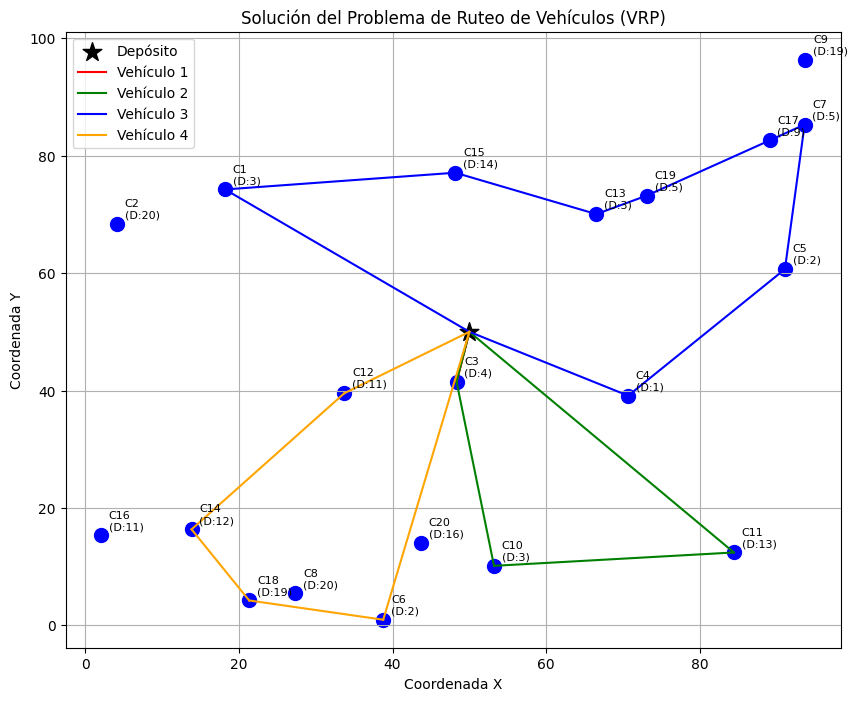

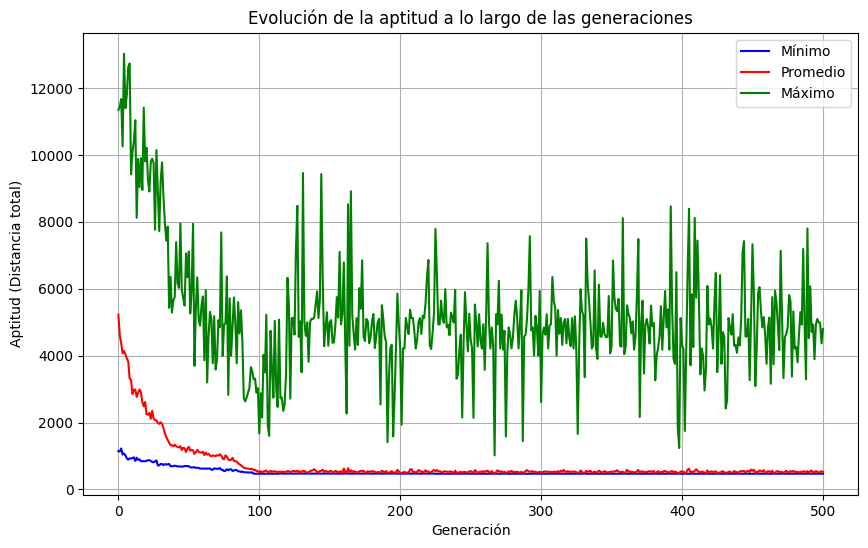

In [33]:
# Visualizar la solución
def visualizar_solucion(rutas):
    plt.figure(figsize=(10, 8))
    
    # Graficar el depósito como un punto negro más grande
    plt.scatter(deposito.x, deposito.y, c='black', s=200, marker='*', label='Depósito')
    
    # Graficar los clientes
    for cliente in clientes:
        plt.scatter(cliente.x, cliente.y, c='blue', s=100)
        plt.text(cliente.x + 1, cliente.y + 1, f'C{cliente.id}\n(D:{cliente.demanda})', fontsize=8)
    
    # Colores para las rutas
    colores = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    # Graficar las rutas
    for i, ruta in enumerate(rutas):
        if not ruta:
            continue
            
        color = colores[i % len(colores)]
        
        # Del depósito al primer cliente
        plt.plot([deposito.x, clientes[ruta[0]-1].x], [deposito.y, clientes[ruta[0]-1].y], c=color, linestyle='-')
        
        # Entre clientes
        for j in range(len(ruta) - 1):
            cliente1 = clientes[ruta[j]-1]
            cliente2 = clientes[ruta[j+1]-1]
            plt.plot([cliente1.x, cliente2.x], [cliente1.y, cliente2.y], c=color, linestyle='-')
        
        # Del último cliente al depósito
        plt.plot([clientes[ruta[-1]-1].x, deposito.x], [clientes[ruta[-1]-1].y, deposito.y], c=color, linestyle='-')
        
        # Leyenda para cada ruta
        plt.plot([], [], c=color, label=f'Vehículo {i+1}')
    
    plt.title('Solución del Problema de Ruteo de Vehículos (VRP)')
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.legend()
    plt.grid(True)
    plt.savefig('solucion_vrp.png')
    plt.show()

# Extraer y visualizar las rutas del mejor individuo
mejores_rutas = extraer_rutas(mejor)
distancia_mejor = calcular_distancia_total(mejores_rutas)

print(f"Mejor distancia encontrada: {distancia_mejor:.2f}")
print("Rutas de los vehículos:")

for i, ruta in enumerate(mejores_rutas):
    if not ruta:
        continue
    carga = sum(clientes[id-1].demanda for id in ruta)
    print(f"Vehículo {i+1}: {ruta} (Carga: {carga}/{CAPACIDAD_VEHICULO})")

# Visualizar la solución
visualizar_solucion(mejores_rutas)

# Graficar la evolución de la aptitud
plt.figure(figsize=(10, 6))
gen = log.select("gen")
fit_mins = log.select("min")
fit_avgs = log.select("avg")
fit_maxs = log.select("max")

plt.plot(gen, fit_mins, "b-", label="Mínimo")
plt.plot(gen, fit_avgs, "r-", label="Promedio")
plt.plot(gen, fit_maxs, "g-", label="Máximo")

plt.title("Evolución de la aptitud a lo largo de las generaciones")
plt.xlabel("Generación")
plt.ylabel("Aptitud (Distancia total)")
plt.legend(loc="upper right")
plt.grid(True)
plt.savefig('evolucion_vrp.png')
plt.show()